# COSC522 Fall 2022 Final Project

## Team Members
Dan Scott <br>
Adam McDaniel<br>
Logan Wrinkle<br>

This notebook sets up the labels and models for the 3-LDR configuration.

In [1]:
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
from datetime import datetime
import datetime
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

## Gather Data from raw LDR values

The data for the 3-LDR models was captured on the Raspberry Pi and transfered to the raw data folder. A file of 100+ events was produced for each direction and saved with the direction (D0, D1,...) in the file name to make identification by programatic means possible.

In [2]:
root = os.getcwd()
data = '../data/raw_data_do_not_edit/'

#list of all CSV files in directory
list_of_all_files = glob(os.path.join(data, 'output_3*.txt'))
list_of_all_files.sort()
from pprint import pprint  
pprint(list(enumerate(list_of_all_files, start=0)))

[(0, '../data/raw_data_do_not_edit\\output_3_D0_b.txt'),
 (1, '../data/raw_data_do_not_edit\\output_3_D1_b.txt'),
 (2, '../data/raw_data_do_not_edit\\output_3_D2_b.txt'),
 (3, '../data/raw_data_do_not_edit\\output_3_D3_b.txt'),
 (4, '../data/raw_data_do_not_edit\\output_3_D4_b.txt'),
 (5, '../data/raw_data_do_not_edit\\output_3_D5_b.txt'),
 (6, '../data/raw_data_do_not_edit\\output_3_D6_b.txt'),
 (7, '../data/raw_data_do_not_edit\\output_3_D7_b.txt')]


In [3]:
#General purpose read CSV with NO data types infered, this is needed because the time stamp does not auto convert using pandas
def getCSVData(fname):
    List_data=[]
    with open(fname) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            List_data.append(row)
            line_count+=1  
    return List_data

## Global parameters for identifing the events based on the average percent change over N rows

In [4]:
N = 18       # Rolling average over N rows
rLen = 20    # use this many rows of data to predict 
PCT = 0.01   # flag if any change in percentage from previous row changes by PCT

## Labeling Data
### Add columns that will help identify an 'Event'

In [5]:
def fixDF(datafrm, direction):
    datafrm['Class']= 'D99'

    LDR_Data_type = 'int64'

    # datafrm['TimeNS'] = datafrm['TimeNS'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)).strftime('%c'))
    datafrm['LDR0'] = datafrm['LDR0'].astype(LDR_Data_type)
    datafrm['LDR1'] = datafrm['LDR1'].astype(LDR_Data_type)
    datafrm['LDR2'] = datafrm['LDR2'].astype(LDR_Data_type)
   
    #Calculate the rolling window average for N rows
    datafrm['AVG_LDR0'] = datafrm['LDR0'].rolling(N).mean()
    datafrm['AVG_LDR1'] = datafrm['LDR1'].rolling(N).mean()
    datafrm['AVG_LDR2'] = datafrm['LDR2'].rolling(N).mean()

    #calculate the PCT change from the previous row of the movign average
    datafrm['CHG_LDR0'] = datafrm['AVG_LDR0'].pct_change()      # (current value - previous value ) / current value
    datafrm['CHG_LDR1'] = datafrm['AVG_LDR1'].pct_change()
    datafrm['CHG_LDR2'] = datafrm['AVG_LDR2'].pct_change()

    #if the PCT change of the rolling average is >= %PCT% (0.01), then create a flag 
    datafrm['BIN_LDR0'] = datafrm['CHG_LDR0'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR1'] = datafrm['CHG_LDR1'].apply(lambda x: 1 if x >= PCT else 0)
    datafrm['BIN_LDR2'] = datafrm['CHG_LDR2'].apply(lambda x: 1 if x >= PCT else 0)
    
    #accumulate the flags
    datafrm['BIN_SUM'] = datafrm['BIN_LDR0'] + datafrm['BIN_LDR1'] + datafrm['BIN_LDR2'] 
    
    datafrm['Class'] = datafrm['BIN_SUM'].apply(lambda x: direction if x>=1 else 'D99')
    return datafrm


### Process all the labeled files and create the 

In [6]:
def getFileName(f):
    """get the file name without extension """
    r = f.split("\\",1)[-1]
    return r.split(".",1)[0]


#look up the class ID using the file name; it requires the file naming convention like output_3_D0....txt
def getClass(f):
    """Return the class label based on the the first occurance of the regular expression find D[0-9]"""
    r = re.search(r'D[0-9]', f)
    return r[0]

i=0
for x in list_of_all_files:
    i+=1
    direction = getClass(getFileName(x))
    df = pd.DataFrame(getCSVData(x), columns=['TimeNS', 'LDR0', 'LDR1', 'LDR2'])
    df = fixDF(df,direction)
    saveName = f'..\\data\\df_3_{direction}_{i}.csv'
    df.to_csv(saveName, index=False)
    

## Load Labeled Data

In [7]:
path = '../data/'
all_files = glob(os.path.join(path, "df_3*.csv"))

df_3a = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [8]:
df_3a.dropna(inplace=True)
df_3a.reset_index(inplace=True,drop=True)

In [9]:
df_3a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177677 entries, 0 to 177676
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   TimeNS    177677 non-null  float64
 1   LDR0      177677 non-null  int64  
 2   LDR1      177677 non-null  int64  
 3   LDR2      177677 non-null  int64  
 4   Class     177677 non-null  object 
 5   AVG_LDR0  177677 non-null  float64
 6   AVG_LDR1  177677 non-null  float64
 7   AVG_LDR2  177677 non-null  float64
 8   CHG_LDR0  177677 non-null  float64
 9   CHG_LDR1  177677 non-null  float64
 10  CHG_LDR2  177677 non-null  float64
 11  BIN_LDR0  177677 non-null  int64  
 12  BIN_LDR1  177677 non-null  int64  
 13  BIN_LDR2  177677 non-null  int64  
 14  BIN_SUM   177677 non-null  int64  
dtypes: float64(7), int64(7), object(1)
memory usage: 20.3+ MB


In [10]:
df_3a.head()

,TimeNS,LDR0,LDR1,LDR2,Class,AVG_LDR0,AVG_LDR1,AVG_LDR2,CHG_LDR0,CHG_LDR1,CHG_LDR2,BIN_LDR0,BIN_LDR1,BIN_LDR2,BIN_SUM
0,1.669577e+09,4800,4992,4800,D99,4800.0,4974.222222,4800.0,0.0,0.000715,0.0,0,0,0,0
1,1.669577e+09,4800,4992,4800,D99,4800.0,4974.222222,4800.0,0.0,0.000000,0.0,0,0,0,0
2,1.669577e+09,4800,4992,4800,D99,4800.0,4974.222222,4800.0,0.0,0.000000,0.0,0,0,0,0
3,1.669577e+09,4800,4928,4800,D99,4800.0,4970.666667,4800.0,0.0,-0.000715,0.0,0,0,0,0
4,1.669577e+09,4800,4992,4800,D99,4800.0,4974.222222,4800.0,0.0,0.000715,0.0,0,0,0,0


### Now calculate the center of mass for N lines/event 

The caclculation starts at the first change in average for any columns (PCT >.01)

only take the center of mass columns for rLen rows 

In [11]:
# iterating over rows using iterrows() function
indxs=[]
j=0
cls='D99'
for index, row in df_3a.iterrows():
    if row['BIN_SUM'] >= 1:
        cls=row['Class']    #pick up the class from the first row
        if (index != (j)):
            if (index != (j+1)):
                indxs.append([index,cls])
                # print (index, cls)
            cls=row['Class']
            j=index
                
new_data=[]
for a,b in indxs:
    Cx = ndimage.center_of_mass(df_3a.iloc[a:a+rLen,8].values)
    Cy = ndimage.center_of_mass(df_3a.iloc[a:a+rLen,9].values)
    Cz = ndimage.center_of_mass(df_3a.iloc[a:a+rLen,10].values)
    new_data.append([Cx, Cy, Cz, b])
    
new_df_1 = pd.DataFrame(new_data,columns=['Cx', 'Cy', 'Cz', 'Class'])
new_df_1.to_csv('..\\data\\CM_100_3.csv',index=False)

In [12]:
# These are the center-of-mass calcuations for each LDR for each event (used for prediction)
new_df_1.head(10)

,Cx,Cy,Cz,Class
0,"(10.70313307068195,)","(7.101213443440939,)","(6.194676375479703,)",D0
1,"(11.497466311220398,)","(8.926100733262997,)","(7.275829384158091,)",D0
2,"(9.259816498830853,)","(6.040270318540881,)","(4.7870030053930055,)",D0
3,"(8.016066869237445,)","(4.898248859828677,)","(4.004920363446906,)",D0
4,"(9.350625882363204,)","(6.534217085093052,)","(4.991108255510789,)",D0
5,"(10.139654224489897,)","(7.329727852743923,)","(5.504438222968223,)",D0
6,"(8.183322016532886,)","(5.55372362283491,)","(3.9685924253175444,)",D0
7,"(9.249498952429672,)","(6.287101064316767,)","(4.913391689995697,)",D0
8,"(7.182527146404501,)","(4.080917471868204,)","(3.0254427103296537,)",D0
9,"(9.19282904283354,)","(6.096474699052759,)","(4.826174977708265,)",D0


In [13]:
new_df_1['Class'].value_counts()

D4    217
D3    213
D6    211
D5    204
D0    202
D1    201
D7    200
D2    197
Name: Class, dtype: int64

In [14]:
df_3 = pd.concat([new_df_1['Cx'].apply(pd.Series),
                  new_df_1['Cy'].apply(pd.Series),
                  new_df_1['Cz'].apply(pd.Series),
                  new_df_1['Class']], axis = 1)


In [15]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1645 non-null   float64
 1   0       1645 non-null   float64
 2   0       1645 non-null   float64
 3   Class   1645 non-null   object 
dtypes: float64(3), object(1)
memory usage: 51.5+ KB


In [16]:
df_3.dropna(inplace=True)

## Split data into Train/Test and Labeled data sets

In [17]:
from sklearn.preprocessing import LabelEncoder
X3 = df_3.iloc[:,:-1]
X3.columns=['Cx', 'Cy', 'Cz']
le = LabelEncoder()
y3 = le.fit_transform(df_3['Class'])

In [18]:
X3.head()

,Cx,Cy,Cz
0,10.703133,7.101213,6.194676
1,11.497466,8.926101,7.275829
2,9.259816,6.040270,4.787003
3,8.016067,4.898249,4.004920
4,9.350626,6.534217,4.991108


In [19]:
#Split data into test and training data sets
X_train, X_test, y_train, y_test = train_test_split(X3.values, y3, test_size=0.30, random_state=45,stratify=np.array(y3)) 


## RandomForestClassifier

In [20]:
#training the model
from sklearn.datasets import make_classification


model = RandomForestClassifier(random_state=42,n_estimators=100,criterion='gini',class_weight='balanced')

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = model.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9913043478260869


Confusion Matrix:
[[61  0  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0  0]
 [ 0  0 58  1  0  0  0  0]
 [ 0  0  0 64  0  0  0  0]
 [ 0  0  0  0 64  1  0  0]
 [ 0  0  0  0  0 61  0  0]
 [ 0  0  0  0  0  0 64  0]
 [ 0  0  0  0  0  0  1 59]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        60
           2       1.00      0.98      0.99        59
           3       0.98      1.00      0.99        64
           4       1.00      0.98      0.99        65
           5       0.98      1.00      0.99        61
           6       0.98      1.00      0.99        64
           7       1.00      0.98      0.99        60

    accuracy                           0.99       494
   macro avg       0.99      0.99      0.99       494
weighted avg       0.99      0.99      0.99       494



Testing Accuracy: 0.993927

In [21]:
#save this awesome RF model as full_file_RF.mod
import pickle
filename = '3LDR_RF.sav'
pickle.dump(model, open(filename, 'wb'))


## HistGradientBoostingClassifier


In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier() 
clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')


#testing the model
ypred = clf.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9782833583208396


Confusion Matrix:
[[61  0  0  0  0  0  0  0]
 [ 1 59  0  0  0  0  0  0]
 [ 0  0 58  1  0  0  0  0]
 [ 0  0  1 63  0  0  0  0]
 [ 0  0  0  0 64  1  0  0]
 [ 0  0  0  0  1 60  0  0]
 [ 0  0  0  0  0  0 63  1]
 [ 0  0  0  0  0  0  0 60]]


Test Statistics:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       1.00      0.98      0.99        60
           2       0.98      0.98      0.98        59
           3       0.98      0.98      0.98        64
           4       0.98      0.98      0.98        65
           5       0.98      0.98      0.98        61
           6       1.00      0.98      0.99        64
           7       0.98      1.00      0.99        60

    accuracy                           0.99       494
   macro avg       0.99      0.99      0.99       494
weighted avg       0.99      0.99      0.99       494



Testing Accuracy: 0.987854

In [23]:
import pickle
filename = '3LDR_XGB.sav'
pickle.dump(clf, open(filename, 'wb'))

### Test one data point

In [24]:
Cx = (10.98897041,)
Cy = (8.06188478,)
Cz = (6.78354568,)

pred_data = list([[Cx[0], Cy[0], Cz[0]]])
print(pred_data)

clf.predict(pred_data)

[[10.98897041, 8.06188478, 6.78354568]]


array([0])

## Support Vector Classifier

In [25]:
clfs = SVC(kernel='linear',probability=True) #note the default kernel here is 'rbf' - radial basis function

clfs.fit(X_train, y_train)
cv_scores = cross_val_score(clfs, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')


#testing the model
ypred = clfs.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9991304347826088


Confusion Matrix:
[[61  0  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0  0]
 [ 0  0 59  0  0  0  0  0]
 [ 0  0  0 64  0  0  0  0]
 [ 0  0  0  0 65  0  0  0]
 [ 0  0  0  0  0 61  0  0]
 [ 0  0  0  0  0  0 64  0]
 [ 0  0  0  0  0  0  0 60]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        64
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00        61
           6       1.00      1.00      1.00        64
           7       1.00      1.00      1.00        60

    accuracy                           1.00       494
   macro avg       1.00      1.00      1.00       494
weighted avg       1.00      1.00      1.00       494



Testing Accuracy: 1.0


In [26]:
print(clfs.n_support_)

[20 10  7  8 20  6  9  9]


In [27]:
clfs.support_vectors_

array([[ 7.46031912e+00,  5.26754417e+00,  4.00072856e+00],
       [ 7.95899388e+00,  4.93926186e+00,  4.95621836e+00],
       [ 1.01396542e+01,  7.32972785e+00,  5.50443822e+00],
       [ 7.98843971e+00,  5.81281747e+00,  4.51684693e+00],
       [ 6.99974680e+00,  4.87746791e+00,  3.73490218e+00],
       [ 7.61154810e+00,  5.19011295e+00,  4.18607455e+00],
       [ 8.66022135e+00,  6.19190780e+00,  4.87993974e+00],
       [ 6.80648042e+00,  3.71342904e+00,  3.71001218e+00],
       [ 7.95742345e+00,  5.87257395e+00,  4.68610944e+00],
       [ 8.09133110e+00,  5.71939449e+00,  3.65252727e+00],
       [-1.18506696e+02, -3.39109041e+01, -1.48758979e+01],
       [ 8.31776046e+00,  6.11723839e+00,  4.45108690e+00],
       [ 6.28344403e+00,  4.19322663e+00,  2.12807912e+00],
       [ 1.14974663e+01,  8.92610073e+00,  7.27582938e+00],
       [ 8.42962824e+00,  6.02971237e+00,  4.59413744e+00],
       [ 7.58446985e+00,  5.21507846e+00,  4.33350138e+00],
       [ 1.01536000e+01,  7.92524529e+00

In [28]:
clfs.support_

array([   7,   52,   55,   63,   99,  220,  242,  264,  300,  308,  332,
        335,  338,  658,  946, 1026, 1035, 1042, 1045, 1104,   61,   68,
         84,  148,  442,  511,  742,  773,  922,  967,  284,  621,  687,
       1023, 1029, 1086, 1128,  289,  430,  503,  528,  613,  722,  778,
        927,   24,   86,   93,  109,  238,  267,  431,  490,  591,  610,
        626,  739,  806,  835,  840,  936, 1068, 1083, 1098, 1129,  207,
        241,  440,  669,  876, 1055,    4,  154,  200,  400,  526,  540,
        604,  744,  998,    2,  172,  286,  543,  651,  664,  740,  871,
        950])

In [29]:
import pickle
filename = '3LDR_SVC.sav'
pickle.dump(clfs, open(filename, 'wb'))

# Grid Search for best parameters

In [30]:
#Plot all the parameters from the grid search 
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

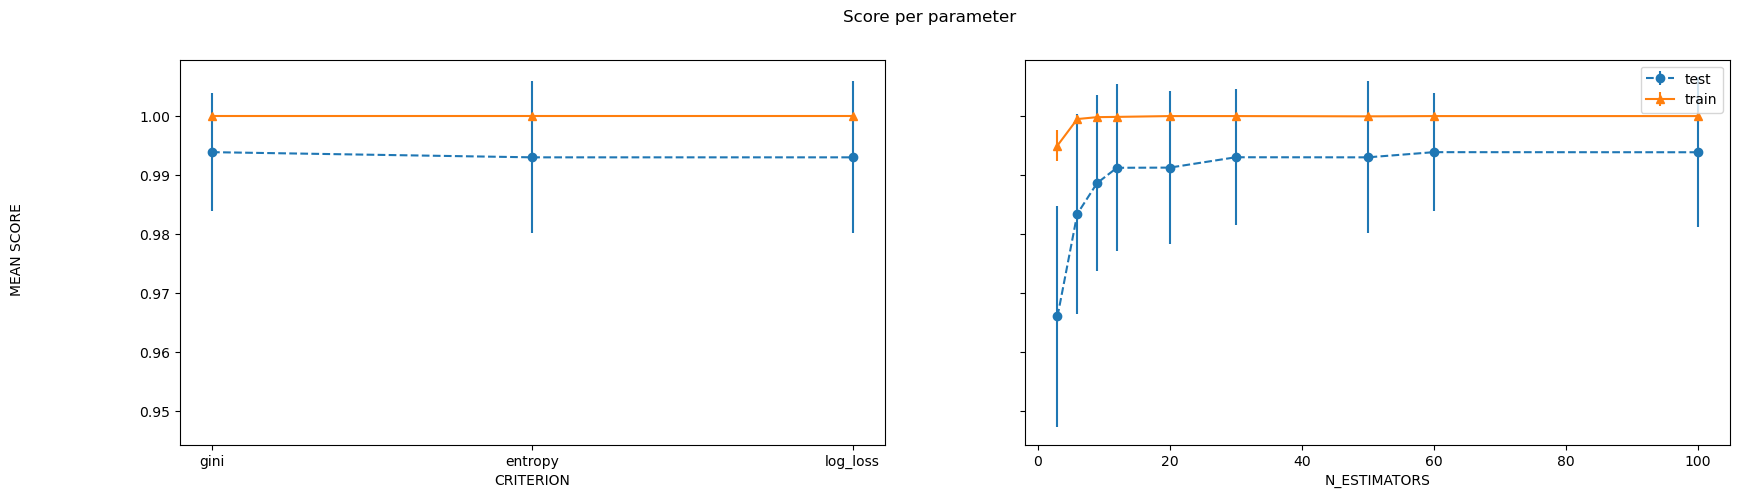

In [31]:
from sklearn.model_selection import GridSearchCV
parameters = { 'n_estimators':[3, 6, 9, 12, 20, 30, 50, 60, 100], 
               'criterion':('gini','entropy','log_loss'),
             }

RFst = RandomForestClassifier(class_weight='balanced', random_state=52)
clf = GridSearchCV(RFst, parameters, cv=20,  return_train_score=True)

clf.fit(X_train, y_train)

plot_search_results(clf)

In [32]:
print(f' Number of rows to average: {N}, number of rows to train/test: {rLen}, {clf.best_params_}, Score: {clf.best_score_}')

 Number of rows to average: 18, number of rows to train/test: 20, {'criterion': 'gini', 'n_estimators': 60}, Score: 0.9938898971566849


In [33]:
#with all the samples 3LDR:
# Number of rows to average: 18, number of rows to train/test: 20, {'criterion':    'gini', 'n_estimators': 60}, Score: 0.9938898971566849
# Number of rows to average: 18, number of rows to train/test: 20, {'criterion': 'entropy', 'n_estimators': 100}, Score: 0.9887174108480672


## Random Forest

In [34]:
#training the model
from sklearn.datasets import make_classification

#Split data into test and training data sets
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.40, random_state=45,stratify=np.array(y3)) 


model = RandomForestClassifier(random_state=42,n_estimators=60,criterion='gini',class_weight='balanced')

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')

#testing the model
ypred = model.predict(X_test)
cm = confusion_matrix(y_test, ypred)
cr = classification_report(y_test, ypred)

print('Confusion Matrix:', cm, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', accuracy_score(y_test, ypred))

Average Cross Validation Score from Training:
0.9939290867862297


Confusion Matrix:
[[80  1  0  0  0  0  0  0]
 [ 0 79  1  0  0  0  0  0]
 [ 0  0 79  0  0  0  0  0]
 [ 0  0  0 85  0  0  0  0]
 [ 0  0  0  0 86  1  0  0]
 [ 0  0  0  0  0 82  0  0]
 [ 0  0  0  0  0  0 84  0]
 [ 0  0  0  0  0  0  0 80]]


Test Statistics:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        81
           1       0.99      0.99      0.99        80
           2       0.99      1.00      0.99        79
           3       1.00      1.00      1.00        85
           4       1.00      0.99      0.99        87
           5       0.99      1.00      0.99        82
           6       1.00      1.00      1.00        84
           7       1.00      1.00      1.00        80

    accuracy                           1.00       658
   macro avg       1.00      1.00      1.00       658
weighted avg       1.00      1.00      1.00       658



Testing Accuracy: 0.995440

In [35]:
model.n_features_in_
# model.n_features_

3